<a href="https://colab.research.google.com/github/daspartho/fastai-part2/blob/main/minibatch_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get the data

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
from torch import tensor
from urllib.request import urlretrieve
from fastcore.test import test_close
torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

with gzip.open(path_gz, 'rb') as f: 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

### Initial Setup

#### Data

In [2]:
n,m = x_train.shape
c = y_train.max()+1
nh=50
n,m,c

(50000, 784, tensor(10))

In [3]:
from torch import nn

class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [
            nn.Linear(n_in, nh), 
            nn.ReLU(),
            nn.Linear(nh, n_out),
        ]
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [4]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

#### Cross entrophy loss

In [5]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [6]:
log_softmax(pred)

tensor([[-2.36, -2.28, -2.09,  ..., -2.43, -2.47, -2.11],
        [-2.37, -2.25, -2.09,  ..., -2.46, -2.43, -2.11],
        [-2.34, -2.31, -2.14,  ..., -2.44, -2.48, -2.14],
        ...,
        [-2.26, -2.25, -2.13,  ..., -2.36, -2.53, -2.17],
        [-2.39, -2.30, -2.18,  ..., -2.38, -2.42, -2.11],
        [-2.40, -2.25, -2.14,  ..., -2.38, -2.45, -2.23]], grad_fn=<SubBackward0>)

In [7]:
def logsumexp(x):
    a = x.max(-1)[0]
    return a + (x-a.unsqueeze(dim=1)).exp().sum(-1).log()

In [8]:
from fastcore.test import test_close
test_close(logsumexp(pred), pred.logsumexp(-1)) # comparing with pytorch's implementation

In [9]:
def log_softmax(x): return x - logsumexp(x).unsqueeze(dim=-1)

In [10]:
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.36, -2.28, -2.09,  ..., -2.43, -2.47, -2.11],
        [-2.37, -2.25, -2.09,  ..., -2.46, -2.43, -2.11],
        [-2.34, -2.31, -2.14,  ..., -2.44, -2.48, -2.14],
        ...,
        [-2.26, -2.25, -2.13,  ..., -2.36, -2.53, -2.17],
        [-2.39, -2.30, -2.18,  ..., -2.38, -2.42, -2.11],
        [-2.40, -2.25, -2.14,  ..., -2.38, -2.45, -2.23]], grad_fn=<SubBackward0>)

In [11]:
y_train[:3]

tensor([5, 0, 4])

In [12]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(tensor(-2.40, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.14, grad_fn=<SelectBackward0>))

In [13]:
sm_pred[[0,1,2],y_train[:3]]

tensor([-2.40, -2.37, -2.14], grad_fn=<IndexBackward0>)

In [14]:
def nll(inp, targ):
    return - inp[range(targ.shape[0]), targ].mean()

In [15]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [16]:
from torch.nn import functional as F
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In [17]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

### Basic training loop

In [18]:
bs = 50

xb = x_train[:bs]
yb = y_train[:bs]
preds = model(xb)
preds.shape

torch.Size([50, 10])

In [19]:
loss_fn = F.cross_entropy
loss_fn(preds, yb)

tensor(2.28, grad_fn=<NllLossBackward0>)

In [20]:
def acc(out, y):
    return (out.argmax(dim=1)==y).float().mean()
acc(preds, yb)

tensor(0.16)

In [21]:
def report(loss, accuracy):
    print(f'loss: {loss:.2f}, accuracy: {accuracy:.2f}')

In [22]:
lr = 0.5
epochs = 3

In [23]:
# basic training loop
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, bs+i))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        with torch.inference_mode():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad*lr
                    l.bias -= l.bias.grad*lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()
    accuracy = acc(preds, yb)
    report(loss, accuracy)

loss: 0.08, accuracy: 0.96
loss: 0.05, accuracy: 0.98
loss: 0.07, accuracy: 0.96


### Using parameters and optim

#### Parameters

In [24]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.l2(self.relu(self.l1(x)))

In [25]:
model = MLP(m, nh, 10)
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [26]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [27]:
for name,l in model.named_children():
    print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [28]:
for p in model.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [29]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n, bs+i))
            xb, yb = x_train[s], y_train[s]
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr   
                model.zero_grad()                 
        accuracy = acc(preds, yb)
        report(loss, accuracy)

In [30]:
fit()

loss: 0.12, accuracy: 0.96
loss: 0.09, accuracy: 0.96
loss: 0.10, accuracy: 0.94


In [31]:
class MyModule():
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
        self.relu = nn.ReLU()

    def __setattr__(self, k, v):
        if not k.startswith('_'):
            self._modules[k] = v
        super().__setattr__(k, v)

    def __repr__(self):
        return f"{self._modules}"

    def parameters(self):
        for l in self._modules.values():
            yield from l.parameters()

In [32]:
module = MyModule(m, nh, 10)
module

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True), 'relu': ReLU()}

In [33]:
for p in module.parameters():
    print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


#### Registering modules

In [34]:
from functools import reduce

In [35]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers=layers
        for i, l in enumerate(self.layers):
            self.add_module(f"layer_{i}", l)
    def forward(self, x):
        return reduce(lambda val, layer: layer(val), self.layers, x)

In [36]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [37]:
model(xb).shape

torch.Size([50, 10])

#### nn.ModuleList

In [38]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [39]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [40]:
fit()

loss: 0.13, accuracy: 0.96
loss: 0.10, accuracy: 0.96
loss: 0.05, accuracy: 0.98


#### nn.Sequential

In [41]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [42]:
fit()

loss: 0.11, accuracy: 0.96
loss: 0.08, accuracy: 0.98
loss: 0.06, accuracy: 0.98


#### Optim

In [43]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self. params = list(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr   
    
    def zero_grad(self):
        for p in self.params:
            p.grad.zero_()   

In [44]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
opt = Optimizer(model.parameters())
loss_fn(model(xb), yb)

tensor(2.29, grad_fn=<NllLossBackward0>)

In [45]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, bs+i))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()               
    accuracy = acc(preds, yb)
    report(loss, accuracy)

loss: 0.15, accuracy: 0.94
loss: 0.08, accuracy: 0.96
loss: 0.08, accuracy: 0.96


In [46]:
from torch import optim

In [47]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
opt = optim.SGD(model.parameters(), lr=lr) 
loss_fn(model(xb), yb)

tensor(2.28, grad_fn=<NllLossBackward0>)

In [48]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, bs+i))
        xb, yb = x_train[s], y_train[s]
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()               
    accuracy = acc(preds, yb)
    report(loss, accuracy)

loss: 0.16, accuracy: 0.96
loss: 0.11, accuracy: 0.96
loss: 0.05, accuracy: 0.98


### Dataset and DataLoader

#### Dataset

In [49]:
class Dataset():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [50]:
train_ds = Dataset(x_train, y_train)
valid_ds = Dataset(x_valid, y_valid)
xb, yb = train_ds[:5]
xb.shape, yb.shape

(torch.Size([5, 784]), torch.Size([5]))

In [51]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
opt = optim.SGD(model.parameters(), lr=lr)

In [52]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n, bs+i))
        xb, yb = train_ds[s]
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()               
    accuracy = acc(preds, yb)
    report(loss, accuracy)

loss: 0.14, accuracy: 0.92
loss: 0.11, accuracy: 0.96
loss: 0.07, accuracy: 0.98


#### DataLoader

In [53]:
class DataLoader():
    def __init__(self, ds, bs):
        self.ds = ds
        self.bs = bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            s = slice(i, min(len(self.ds), self.bs+i))
            yield self.ds[s]

In [54]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [55]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [56]:
def get_model():
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))
    opt = optim.SGD(model.parameters(), lr=lr)
    return model, opt

def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()               
        accuracy = acc(preds, yb)
        report(loss, accuracy)

In [57]:
model, opt = get_model()
fit()

loss: 0.10, accuracy: 0.98
loss: 0.08, accuracy: 0.96
loss: 0.07, accuracy: 0.98


### Random sampling

In [58]:
import random

In [59]:
class Sampler():
    def __init__(self, ds, shuffle=False):
        self.n = len(ds)
        self.shuffle = shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle:
            random.shuffle(res)
        return iter(res)

In [60]:
ss = Sampler(train_ds)
it = iter(ss)
for o in range(5):
    print(next(it))

0
1
2
3
4


In [61]:
ss = Sampler(train_ds, shuffle=True)
it = iter(ss)
for o in range(5):
    print(next(it))

12521
2966
16155
20336
39561


In [62]:
import fastcore.all as fc

In [63]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False):
        fc.store_attr()
    def __iter__(self):
        yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [64]:
batchs = BatchSampler(ss, 4)
it = iter(batchs)
for o in range(5):
    print(next(it))

[2036, 16678, 7874, 48188]
[11765, 1303, 33001, 8632]
[49232, 23814, 41816, 25427]
[40356, 41049, 4265, 18514]
[36711, 5053, 26672, 43320]


In [65]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

In [66]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate):
        fc.store_attr()
    def __iter__(self):
            yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [67]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [68]:
train_dl = DataLoader(train_ds, train_samp)
valid_dl = DataLoader(valid_ds, valid_samp)

tensor(7)

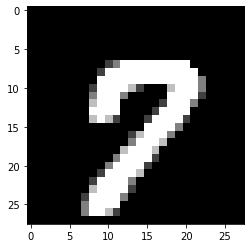

In [69]:
import matplotlib.pyplot as plt

xb, yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [70]:
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [71]:
model, opt = get_model()
fit()

loss: 0.03, accuracy: 1.00
loss: 0.12, accuracy: 0.94
loss: 0.19, accuracy: 0.98


### Multiprocessing DataLoader

In [72]:
import torch.multiprocessing as mp

In [73]:
train_ds[[4,5,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([9, 2, 1, 3]))

In [74]:
train_ds.__getitem__([4,5,6,7])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([9, 2, 1, 3]))

In [75]:
for o in map(train_ds.__getitem__, ([4,5],[6,7])):
    print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([9, 2]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 3]))


In [76]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate):
        fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex:
            yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [77]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [78]:
xb, yb = next(it)
xb.shape, yb.shape

(torch.Size([50, 784]), torch.Size([50]))

### Pytorch DataLoader

In [79]:
from torch.utils.data import DataLoader, BatchSampler, SequentialSampler, RandomSampler

In [80]:
train_samp = BatchSampler(RandomSampler(train_ds), bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [81]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [82]:
model, opt = get_model()
print(loss_fn(model(xb), yb))
fit()

tensor(2.31, grad_fn=<NllLossBackward0>)
loss: 0.07, accuracy: 1.00
loss: 0.13, accuracy: 0.94
loss: 0.18, accuracy: 0.94


auto-generating batch sampler

In [83]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

auto-generating Sequential/RandomSamplers too

In [84]:
train_dl = DataLoader(train_ds, bs, shuffle=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [85]:
model, opt = get_model()
print(loss_fn(model(xb), yb))
fit()

tensor(2.32, grad_fn=<NllLossBackward0>)
loss: 0.15, accuracy: 0.94
loss: 0.23, accuracy: 0.96
loss: 0.05, accuracy: 0.98


### Validation

In [86]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):

    for epoch in range(epochs):
        
        model.train()
        for xb, yb in train_dl:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():   
            t_loss, t_acc, n = 0.,0.,0
            for xb, yb in valid_dl:
                preds = model(xb)
                t_loss += loss_fn(preds, yb)
                t_acc += acc(preds, yb)
                n+=1

        report(t_loss/n, t_acc/n)

In [87]:
def get_dls(train_ds, valid_ds, bs):
    train_dl = DataLoader(train_ds, bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, bs*2, shuffle=False)
    return train_dl, valid_dl

In [88]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
fit(5, model, loss_fn, opt, train_dl, valid_dl)

loss: 0.14, accuracy: 0.96
loss: 0.14, accuracy: 0.96
loss: 0.11, accuracy: 0.97
loss: 0.11, accuracy: 0.97
loss: 0.10, accuracy: 0.97
